In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import seaborn as sns; sns.set_theme()
import string
import analysis_functions as funcs
from cartopy import crs as ccrs
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib import (cm, colors,cycler)
import matplotlib.path as mpath
import matplotlib
import xclim as xc

from matplotlib.legend_handler import HandlerTuple

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

def global_mean(ds):
    lat = ds['lat']
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'time'}
    return (ds * weight).mean(other_dims)
                             
def zonal_mean(ds):
    lat = ds['lat']
    other_dims = set(ds.dims) - {'lat'}
    return ds.mean(other_dims)

def tropics_mean(ds):
    ds = ds.where(ds.lat < 20, drop = True)
    ds = ds.where(ds.lat > -20, drop = True)
    lat = ds['lat']
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'time'}
    return (ds * weight).mean(other_dims)

def npolar_mean(ds):
    ds = ds.where(ds.lat > 70, drop = True)
    lat = ds['lat']
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'time'}
    return (ds * weight).mean(other_dims)

def spolar_mean(ds):
    ds = ds.where(ds.lat < -70, drop = True)
    lat = ds['lat']
    weight = np.cos(np.deg2rad(lat))
    weight /= weight.mean()
    other_dims = set(ds.dims) - {'time'}
    return (ds * weight).mean(other_dims)

def make_colourmap(vmin, vmax, n, **kwargs):
    '''
    Makes a colormap from ``vmin`` (inclusive) to ``vmax`` (exclusive) with
    ``n`` boundaries. Optionally includes choice of color and
    to extend the colormap.
    '''
    col = kwargs.pop('col', 'viridis')
    extend = kwargs.pop('extend', 'both')

    boundaries = list(np.linspace(vmin, vmax, n))

    cmap_new = cm.get_cmap(col, len(boundaries) + 1)
    colours = list(cmap_new(np.arange(len(boundaries) + 1)))
    cmap = colors.ListedColormap(colours[1:-1],"")
    cmap.set_over(colours[-1])
    cmap.set_under(colours[0])

    norm = colors.BoundaryNorm(boundaries, ncolors = len(boundaries) - 1,
                               clip = False)
    boundaries = [2*vmin-10]+boundaries+[2*vmax+10]

    return boundaries, cmap, norm

In [3]:
models = []
labels = []
ds_solar = xr.open_mfdataset('/badc/cmip6/data/CMIP6/GeoMIP/MOHC/UKESM1-0-LL/G6solar/r1i1p1f2/day/tasmax/gn/files/d20191031/*')
# solar dimming experiments, surface temperature
models.append(ds_solar)
labels.append('G6solar')

ds_sulfur = xr.open_mfdataset('/badc/cmip6/data/CMIP6/GeoMIP/MOHC/UKESM1-0-LL/G6sulfur/r1i1p1f2/day/tasmax/gn/files/d20191113/*')
# sulfur injection experiment, surface temperature
models.append(ds_sulfur)
labels.append('G6sulfur')

ds_245 = xr.open_mfdataset('/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp245/r1i1p1f2/day/tasmax/gn/v20190715/*')
# ssp 5, rcp8.5, surface temperature
models.append(ds_245)
labels.append('ssp245')

ds_585 = xr.open_mfdataset('/badc/cmip6/data/CMIP6/ScenarioMIP/MOHC/UKESM1-0-LL/ssp585/r1i1p1f2/day/tasmax/gn/v20190726/*')
# ssp 5, rcp8.5, surface temperature
models.append(ds_585)
labels.append('ssp585')

ds_G1 = xr.open_mfdataset('/badc/cmip6/data/CMIP6/GeoMIP/MOHC/UKESM1-0-LL/G1/r1i1p1f2/day/tasmax/gn/files/d20190916/*')
# weak solar dimming perhaps?, surface temperature
labels.append('G1')

ds_piC = xr.open_mfdataset('/badc/cmip6/data/CMIP6/CMIP/MOHC/UKESM1-0-LL/' + \
                           'piControl/r1i1p1f2/day/tasmax/gn/files/d20191008/*')#.isel(time=slice(0,1200))
labels.append('piControl')

In [19]:
modelist = models.copy()

for i in range(len(modelist)):
    m = modelist[i]
    m = m.sel(time = slice("2090", "2100"))
    m = xc.atmos.tx_max(m.tasmax, freq='MS')
    m = m.mean(dim = "time")
    modelist[i] = m

In [4]:
series = models.copy()

series.append(ds_G1)
series.append(ds_piC)

trop = []
npol = []
spol = []
for i in range(len(series)):
    m = series[i]
    m = xc.atmos.tx_max(m.tasmax, freq='MS')
    t = tropics_mean(m)
    npolar = npolar_mean(m)
    spolar = spolar_mean(m)
    trop.append(t)
    npol.append(npolar)
    spol.append(spolar)
    

In [4]:
diffs = []


diffs.append(modelist[0] - modelist[2])
diffs.append(modelist[1] - modelist[2])
diffs.append(modelist[0] - modelist[3])
diffs.append(modelist[1] - modelist[3])
diffs.append(modelist[0] - modelist[1])

0
1
2
3


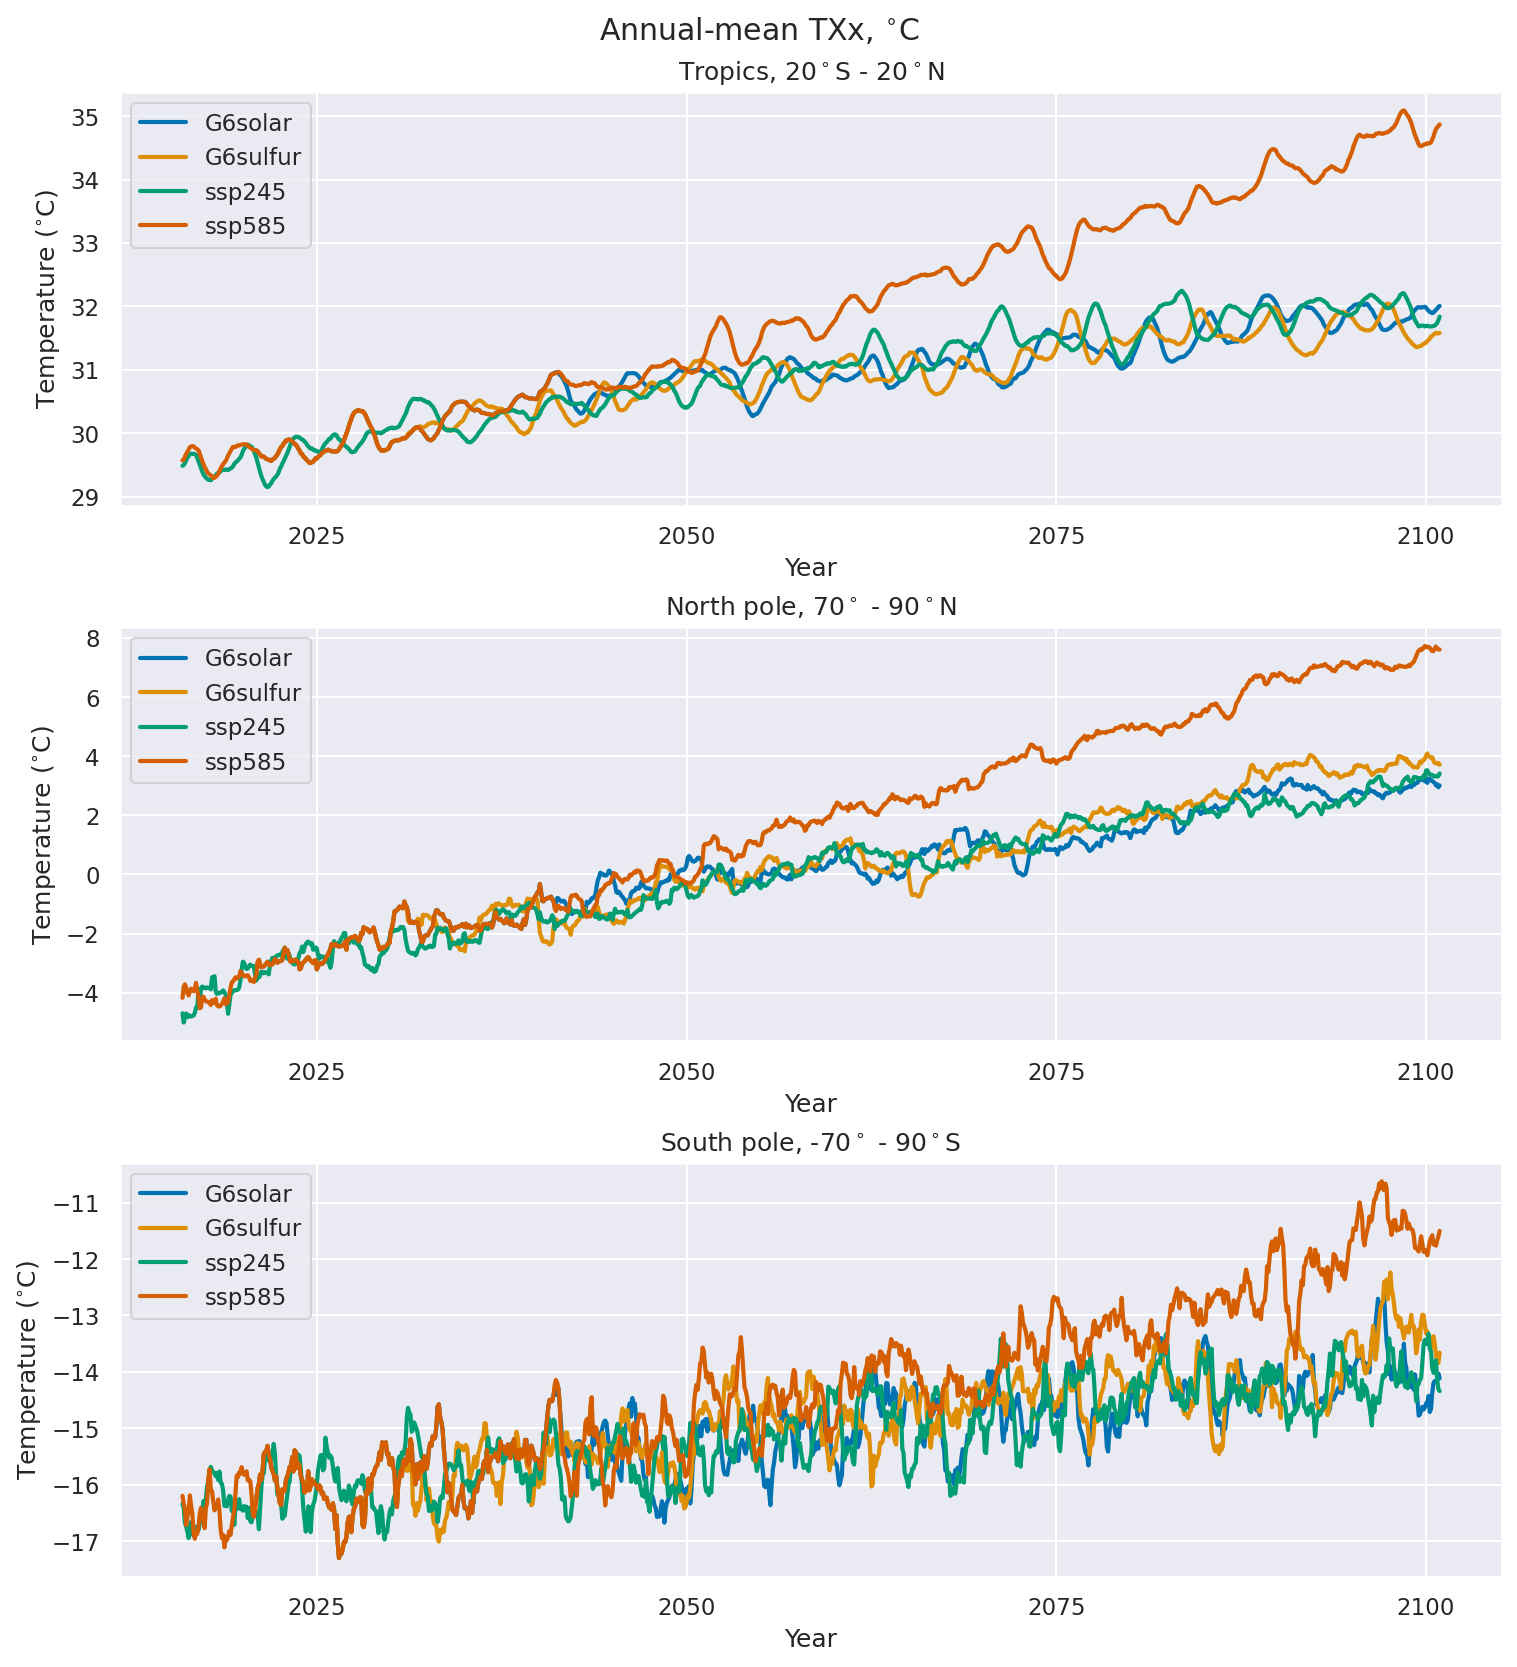

In [10]:
fig = plt.figure(constrained_layout=True, figsize = (10,11), dpi= 150,
                )
ax_dict = fig.subplot_mosaic(
    """
    A
    B
    C
    """,
)

sns.set_theme(palette='colorblind')

for i in range(len(trop)-2):
    dat = [trop[i], npol[i], spol[i]]
    l = labels[i]
    title = ['Tropics, 20$^\circ$S - 20$^\circ$N', 'North pole, 70$^\circ$ - 90$^\circ$N',
            'South pole, -70$^\circ$ - 90$^\circ$S']
    for j, ax in enumerate(fig.axes):
        ax.plot(dat[j].time.values,(dat[j]-273).rolling(time=12).mean().values, lw=2,label=l)
        ax.set_title(title[j])
        ax.set_ylabel('Temperature ($^{\circ}$C)')
        ax.set_xlabel('Year')
        ax.legend()


#plt.ylim([14,22])

fig.suptitle('Annual-mean TXx, $^{\circ}$C')
plt.show()

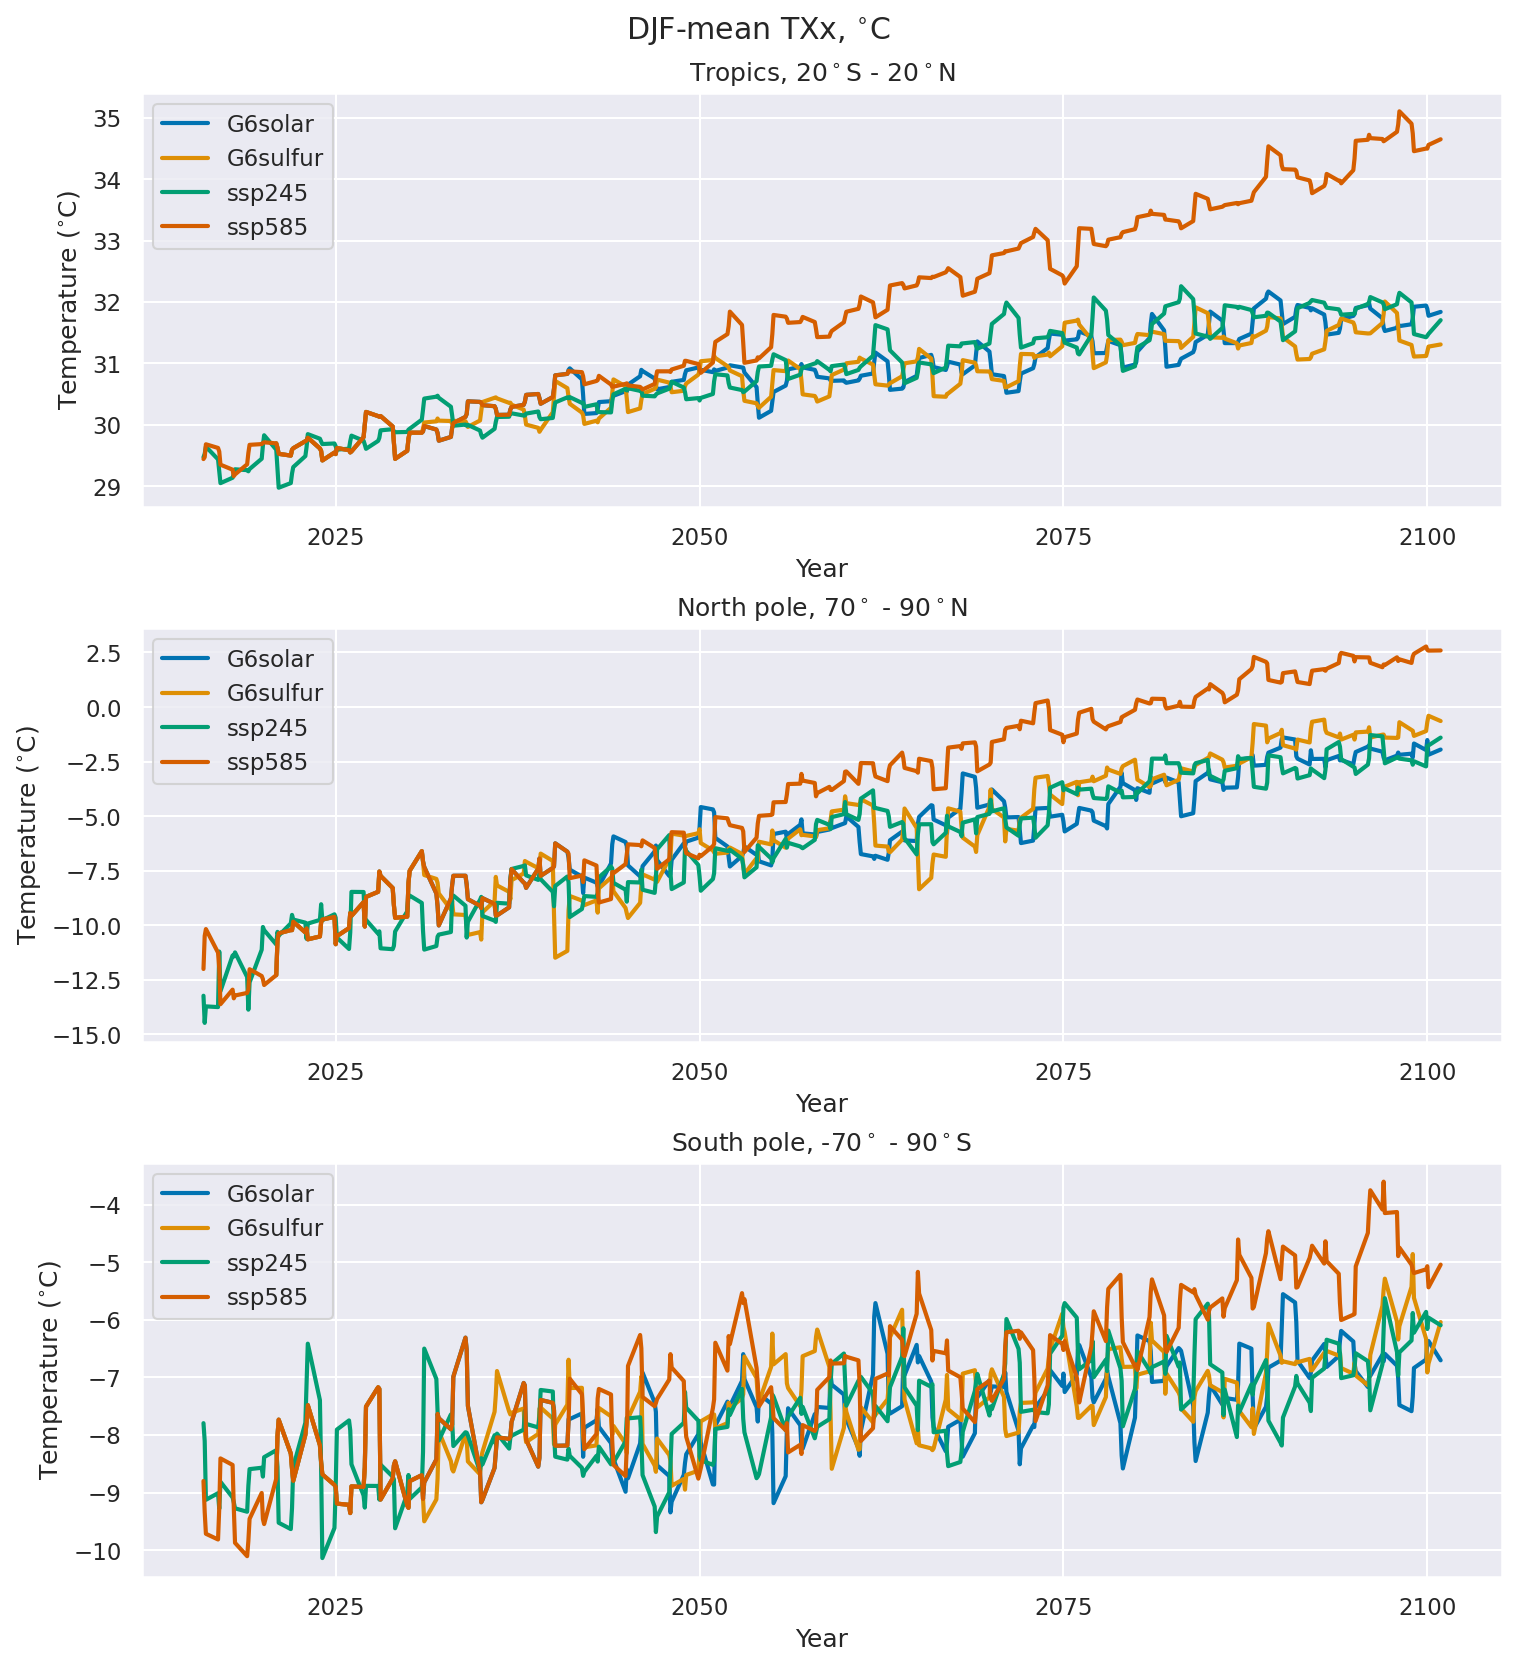

In [29]:
fig = plt.figure(constrained_layout=True, figsize = (10,11), dpi= 150,
                )
ax_dict = fig.subplot_mosaic(
    """
    A
    B
    C
    """,
)

sns.set_theme(palette='colorblind')

for i in range(len(trop)-2):
    dat = [
        trop[i].sel(time=trop[i]['time.season']=="DJF"),
        npol[i].sel(time=npol[i]['time.season']=="DJF"),
        spol[i].sel(time=spol[i]['time.season']=="DJF"),
    ]
    l = labels[i]
    title = ['Tropics, 20$^\circ$S - 20$^\circ$N', 'North pole, 70$^\circ$ - 90$^\circ$N',
            'South pole, -70$^\circ$ - 90$^\circ$S']
    for j, ax in enumerate(fig.axes):
        ax.plot(dat[j].time.values,(dat[j]-273).rolling(time=3).mean().values, lw=2,label=l)
        ax.set_title(title[j])
        ax.set_ylabel('Temperature ($^{\circ}$C)')
        ax.set_xlabel('Year')
        ax.legend()


#plt.ylim([14,22])

fig.suptitle('DJF-mean TXx, $^{\circ}$C')
plt.show()

0
1
2
3


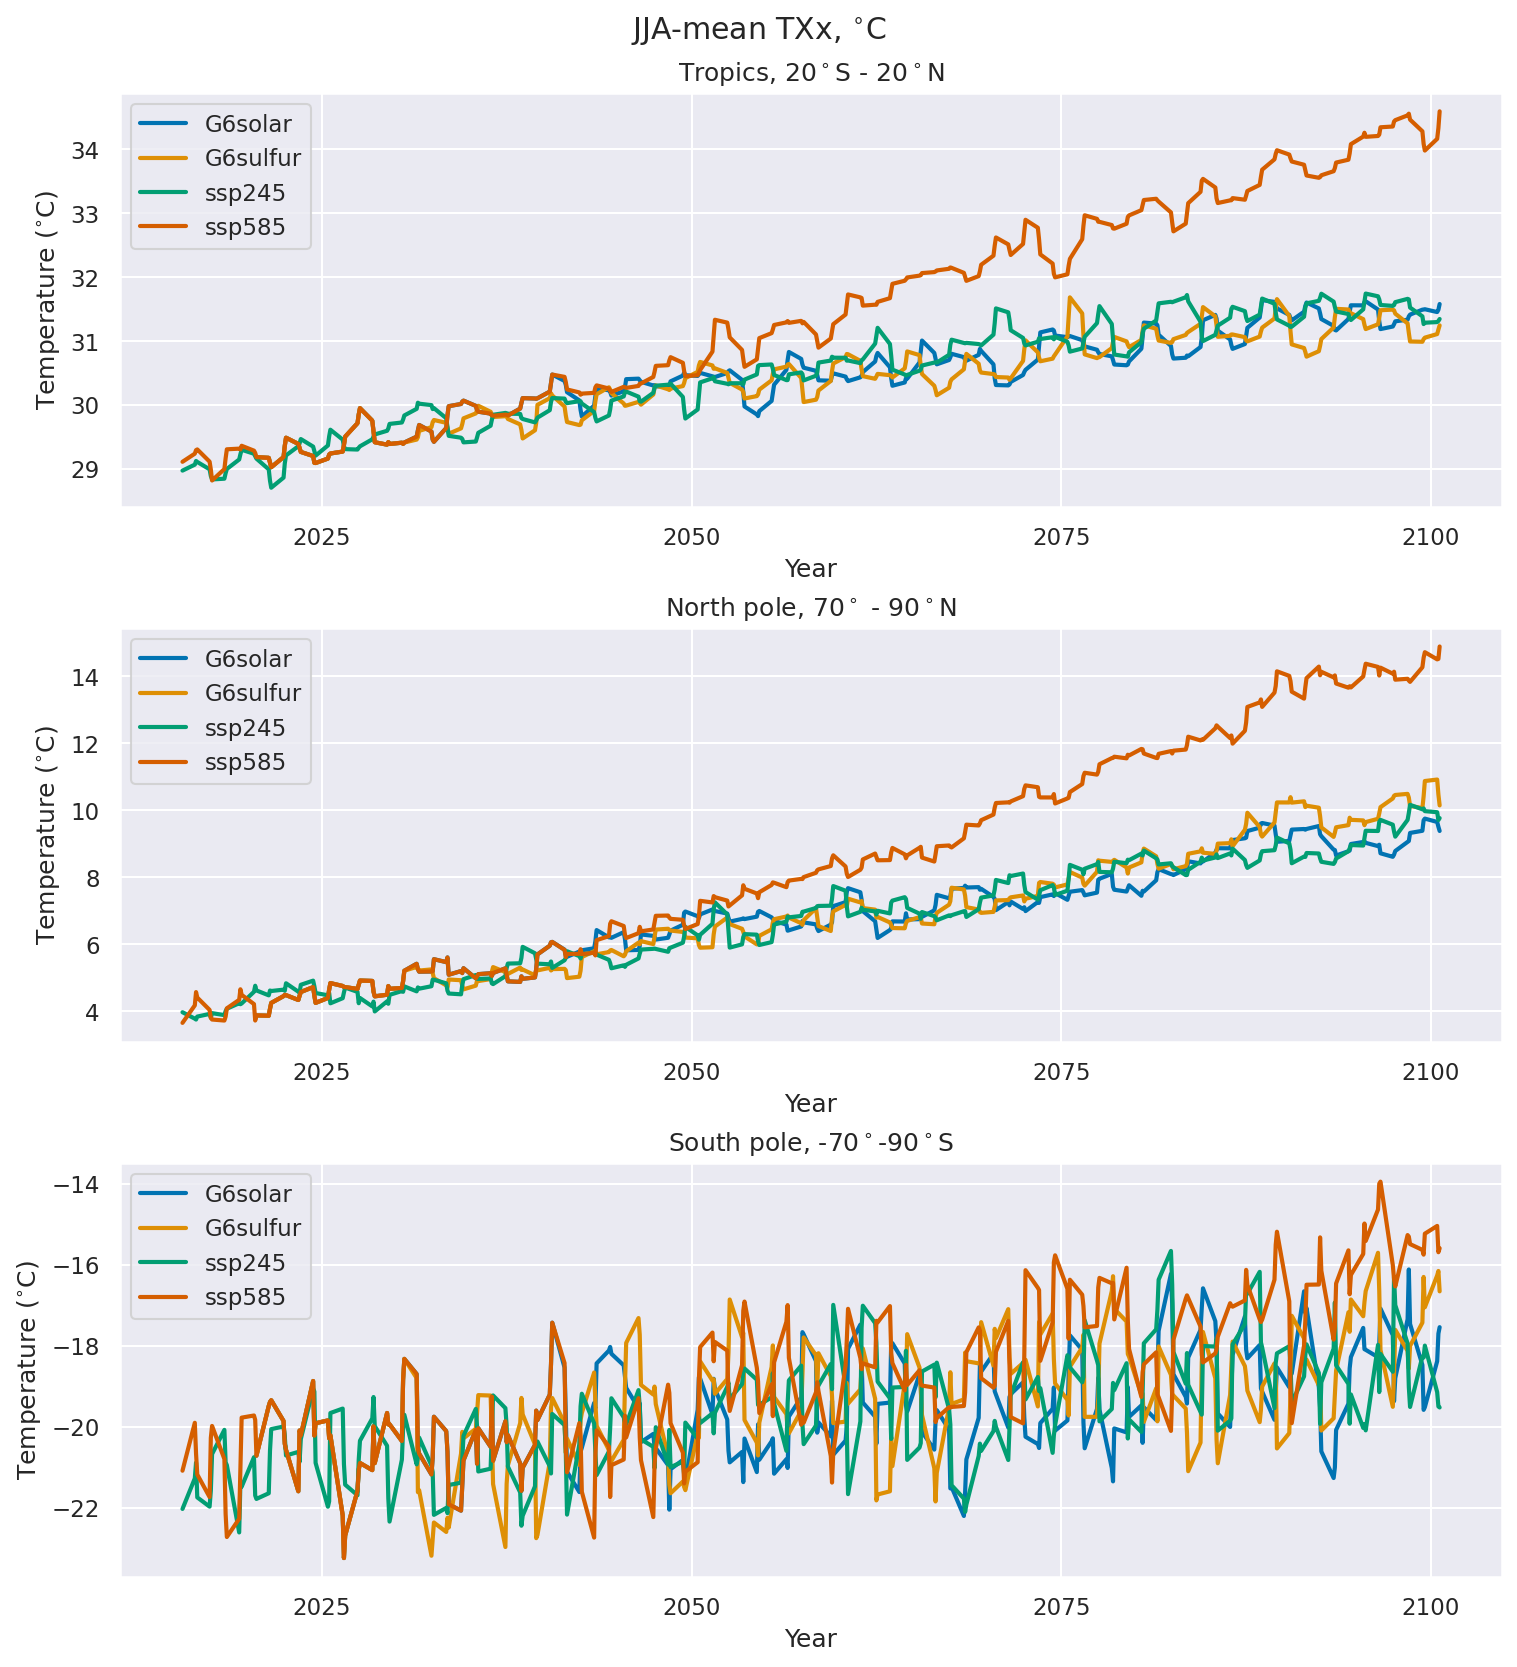

In [28]:
fig = plt.figure(constrained_layout=True, figsize = (10,11), dpi= 150,
                )
ax_dict = fig.subplot_mosaic(
    """
    A
    B
    C
    """,
)

sns.set_theme(palette='colorblind')

for i in range(len(trop)-2):
    dat = [
        trop[i].sel(time=trop[i]['time.season']=="JJA"),
        npol[i].sel(time=npol[i]['time.season']=="JJA"),
        spol[i].sel(time=spol[i]['time.season']=="JJA"),
    ]
    l = labels[i]
    title = ['Tropics, 20$^\circ$S - 20$^\circ$N', 'North pole, 70$^\circ$ - 90$^\circ$N',
            'South pole, -70$^\circ$-90$^\circ$S']
    for j, ax in enumerate(fig.axes):
        ax.plot(dat[j].time.values,(dat[j]-273).rolling(time=3).mean().values, lw=2,label=l)
        ax.set_title(title[j])
        ax.set_ylabel('Temperature ($^{\circ}$C)')
        ax.set_xlabel('Year')
        ax.legend()


#plt.ylim([14,22])

fig.suptitle('JJA-mean TXx, $^{\circ}$C')
plt.show()

In [ ]:
cmap1 = sns.diverging_palette(260,10,s=80, l=55, n=17, as_cmap=True)
cmap2 = sns.light_palette((260, 75, 60), input = "husl", reverse=True,
                          as_cmap=True)
fig = plt.figure(constrained_layout=True, figsize = (10,11), dpi= 150,
                )
ax_dict = fig.subplot_mosaic(
    """
    AABB
    CCDD
    .EE.
    """,
    subplot_kw = {'projection':ccrs.EckertIII()}
)

for j, ax in enumerate(fig.axes):
    dat = diffs[j]
    lon = dat.lon.values
    lat = dat.lat.values
    ax.text(-0.03, 1.03, string.ascii_lowercase[j], transform=ax.transAxes, 
            size=18,)
    gl = ax.gridlines(crs = ccrs.PlateCarree())
    if j < 2:
        l = labels[j]
        ax.set_title(l+' - ssp245')
        levels = np.linspace(-3, 3, 11)
        cmap = cmap1
    elif 2 <= j < 4:
        l = labels[j-2]
        ax.set_title(l+' - ssp585')
        levels = np.linspace(-7,0,8)
        cmap = cmap2
    else:
        ax.set_title(labels[1] + ' - ' + labels[0])
        levels = np.linspace(-2.8,2.8,11)
        cmap = cmap1
    #gl.ylocator = ticker.FixedLocator([-60,-30,0,30,60])
    #gl.xlocator = ticker.FixedLocator([0,60,120,180,240,300,360])
    filled_c = ax.contourf(lon, lat, dat,
           transform=ccrs.PlateCarree(), levels=levels,
           cmap=cmap)
    
    cb = fig.colorbar(filled_c, ax = ax, orientation="horizontal",
                      shrink = 0.8)
    cb.set_label(label = 'Temperature difference (K)')
    #ax.contourf(dat,
    #        projection=ccrs.Robinson())
    ax.coastlines()
    
        
    ax.set_global()

fig.suptitle('Decadal mean daily maximum temperature difference')
plt.show()

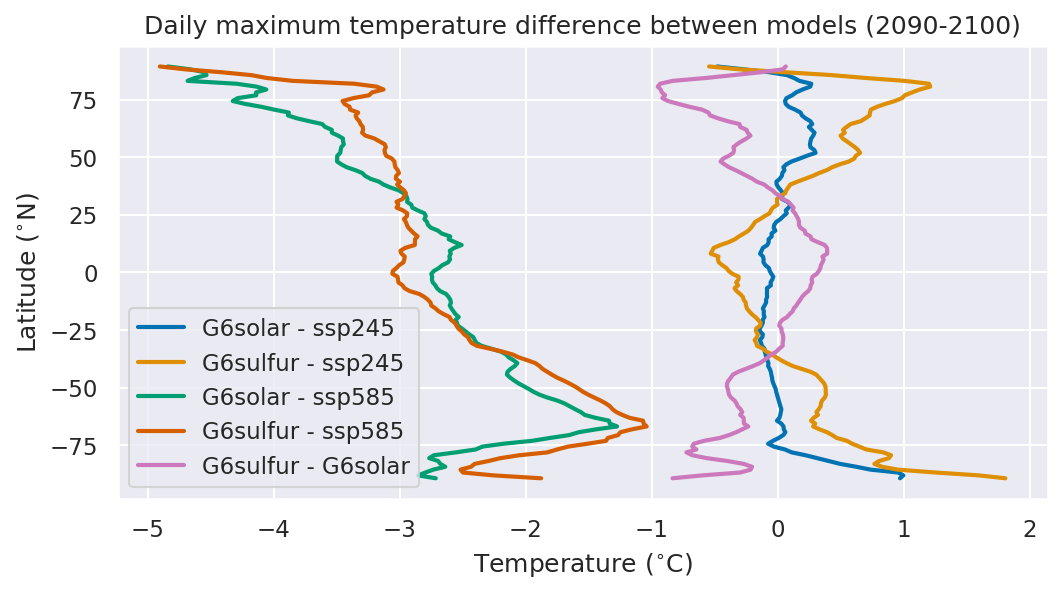

In [8]:
plt.figure(figsize=(8, 4), dpi=150)
sns.set_theme(palette='colorblind')
    
for j in range(len(diffs)):
    dat = diffs[j].mean(dim="lon")
    if j < 2:
        l = labels[j]+' - ssp245'
    elif 2 <= j < 4:
        l = labels[j-2]+' - ssp585'
    else:
        l=labels[1] + ' - ' + labels[0]
    plt.plot(dat,dat.lat,lw=2,label=l)
    
#plt.grid()
#plt.ylim([14,22])
plt.ylabel('Latitude ($^{\circ}$N)')
plt.xlabel('Temperature ($^{\circ}$C)')
plt.legend()
plt.title('Daily maximum temperature difference between models (2090-2100)')
plt.show()
    

In [17]:
ser = models.copy()

ser.append(ds_G1)
ser.append(ds_piC)


winter = []
summer = []
for i in range(len(ser)):
    m = ser[i]
    if i == 4:
        m = m.sel(time = slice("1930","1940"))
    else:
        m = m.sel(time = slice("2090", "2100"))
    #djf = m.sel(time=is_djf(m['time.month']))
    m = xc.atmos.tx_max(m.tasmax, freq='MS')    
    djf = m.sel(time=m['time.season']=="DJF")
    jja = m.sel(time=m['time.season']=="JJA")
    djf = djf.mean(dim="time")
    jja = jja.mean(dim="time")
    winter.append(djf)
    summer.append(jja)

In [21]:
dif1 = []
dif2 = []

dif1.append(summer[1] - summer[3]) # sulf - 585
dif2.append(winter[1] - winter[3]) # sulf - 585
dif1.append(summer[1] - summer[2]) # sulf - 245
dif2.append(winter[1] - winter[2]) # sulf - 245
dif1.append(summer[0] - summer[1]) # sulf - sol
dif2.append(winter[0] - winter[1]) # sulf - sol

dif1.append(summer[0] - summer[2]) # sol - 245
dif2.append(winter[0] - winter[2]) # sol - 245
dif1.append(summer[0] - summer[3]) # sol - 585
dif2.append(winter[0] - winter[3]) # sol - 585

labs = ['SSP585 - G6Sulfur', 'SSP245 - G6Sulfur', 'G6Solar - G6Sulfur']

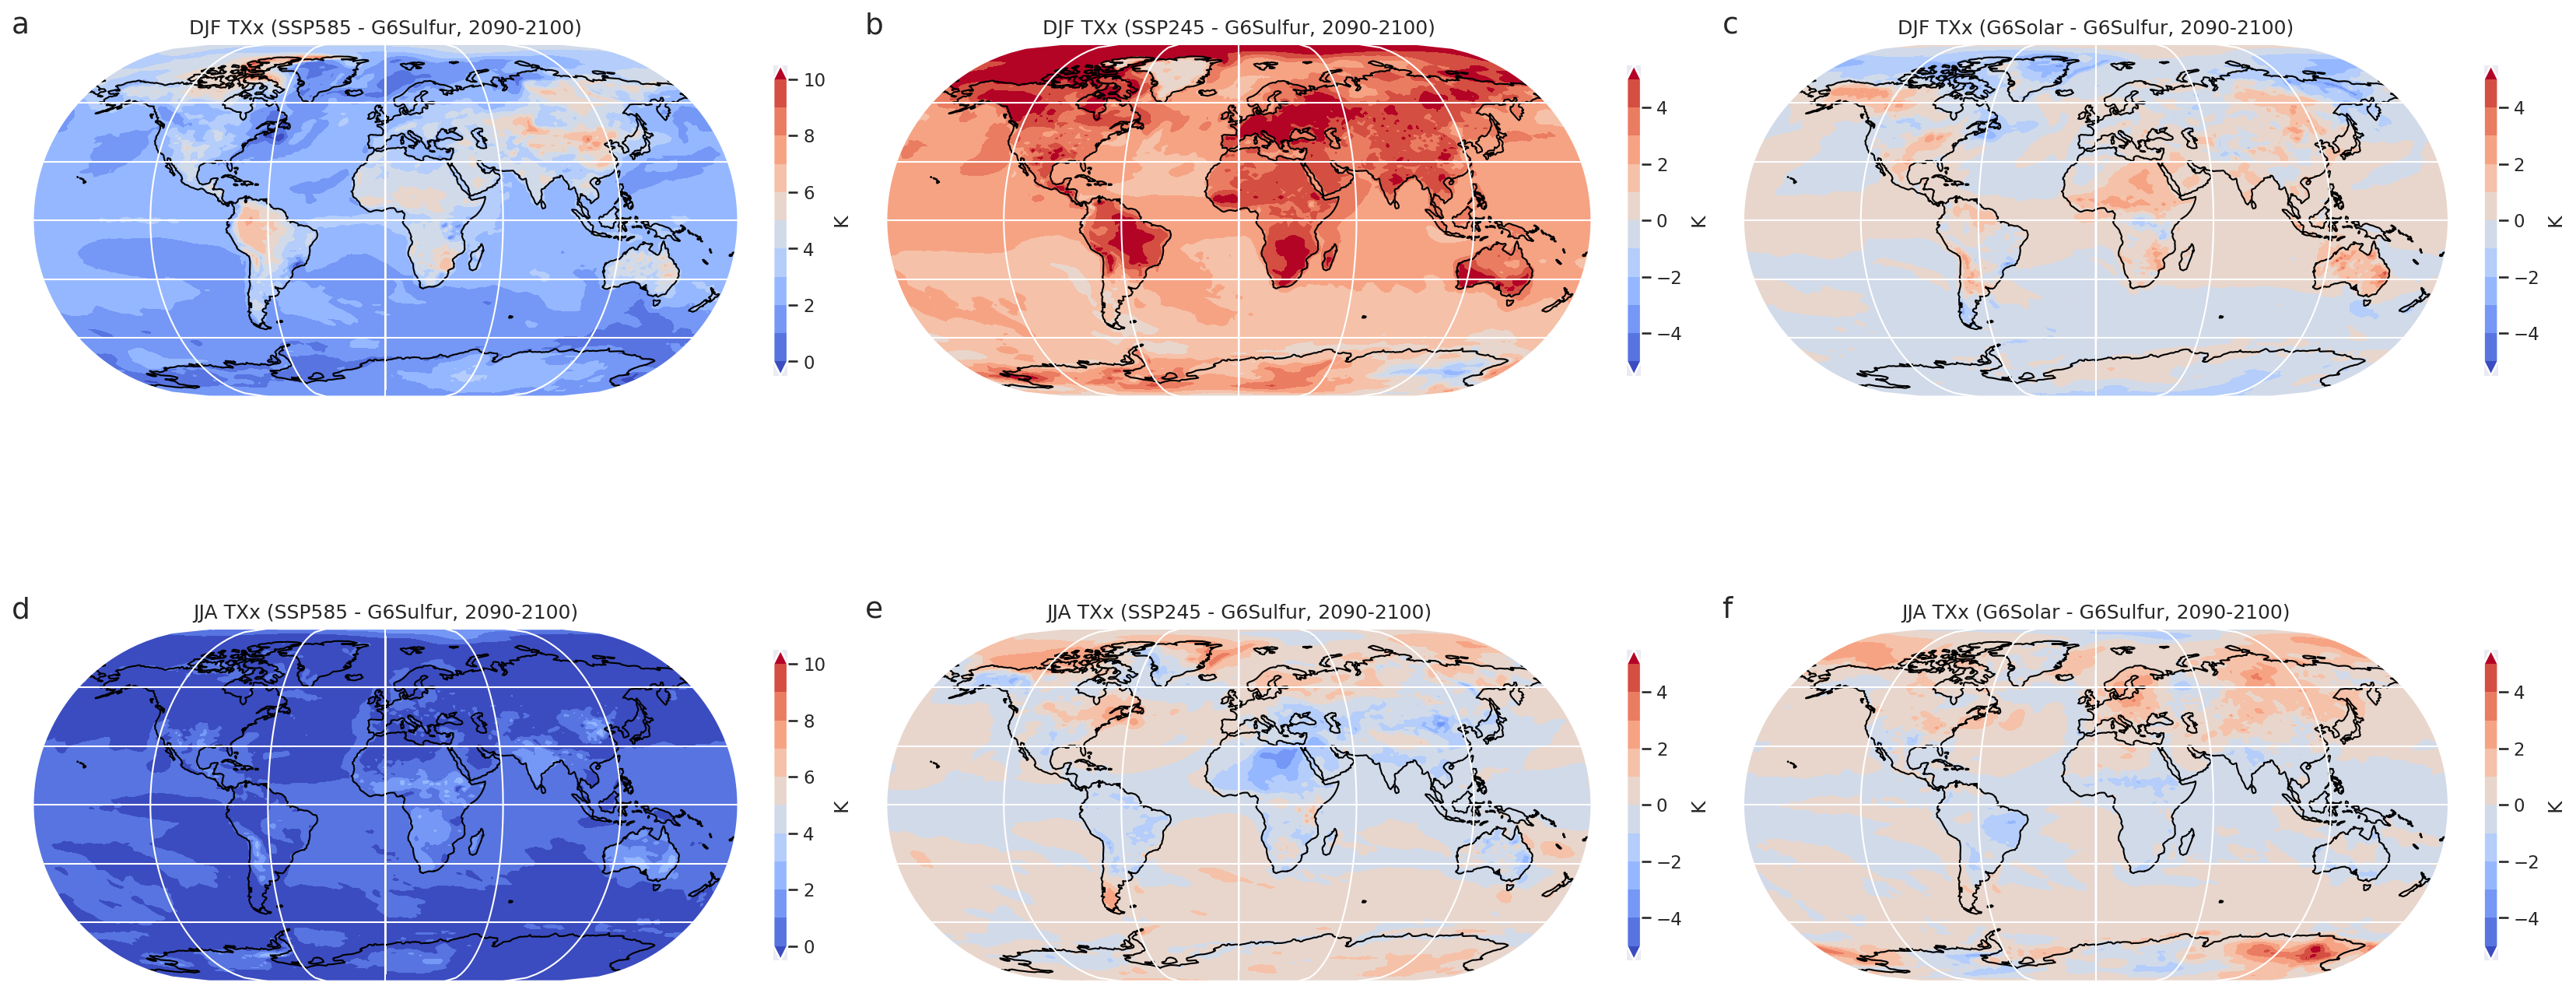

In [40]:
fig = plt.figure(constrained_layout=True, figsize = (22,10), dpi= 150,
                )
ax_dict = fig.subplot_mosaic(
    """
    AABBCC
    DDEEFF
    """,
    subplot_kw = {'projection':ccrs.EckertIII()}
)

for j, ax in enumerate(fig.axes):
    if j % 2:
        dat = -dif1[int(j/2)]
    else:
        dat = -dif2[int(j/2)]
       
    lon = dat.lon.values
    lat = dat.lat.values
    ax.text(-0.03, 1.03, string.ascii_lowercase[j], transform=ax.transAxes, 
            size=18,)
    gl = ax.gridlines(crs = ccrs.PlateCarree())
    if j <= 2:
        l = labs[j] 
        ax.set_title('DJF TXx ('+l+', 2090-2100)')
        #levels = np.linspace(-3, 3, 11)
        #cmap = cmap1
    else:
        l = labs[j-3]
        ax.set_title('JJA TXx ('+l+', 2090-2100)')
        #levels = np.linspace(-7,0,8)
        #cmap = cmap2
    if j == 0 or j == 3:
        levels = np.linspace(0,10,11)
        boundaries, cmap, norm = make_colourmap(0, 10, 11,
                                        col = 'coolwarm')
    else:
        levels=np.linspace(-5,5,11)
        boundaries, cmap, norm = make_colourmap(-5, 5, 11,
                                        col = 'coolwarm')
        
    #gl.ylocator = ticker.FixedLocator([-60,-30,0,30,60])
    #gl.xlocator = ticker.FixedLocator([0,60,120,180,240,300,360])
    filled_c = ax.contourf(lon, lat, dat,
           transform=ccrs.PlateCarree(), levels=boundaries,
           cmap=cmap, norm = norm)
    
    cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax = ax, orientation="vertical",
                      fraction = 0.02, extend = 'both')
    cb.set_label(label = 'K')
    #ax.contourf(dat,
    #        projection=ccrs.Robinson())
    ax.coastlines()
    
        
    ax.set_global()

#fig.suptitle('Decadal mean daily maximum temperature difference')
plt.show()

In [39]:
def make_colourmap(vmin, vmax, n, **kwargs):
    '''
    Makes a colormap from ``vmin`` (inclusive) to ``vmax`` (exclusive) with
    ``n`` boundaries. Optionally includes choice of color and
    to extend the colormap.
    '''
    col = kwargs.pop('col', 'viridis')
    extend = kwargs.pop('extend', 'both')

    boundaries = list(np.linspace(vmin, vmax, n))

    cmap_new = cm.get_cmap(col, len(boundaries) + 1)
    colours = list(cmap_new(np.arange(len(boundaries) + 1)))
    cmap = colors.ListedColormap(colours[1:-1],"")
    cmap.set_over(colours[-1])
    cmap.set_under(colours[0])

    norm = colors.BoundaryNorm(boundaries, ncolors = len(boundaries) - 1,
                               clip = False)
    boundaries = [2*vmin-10]+boundaries+[2*vmax+10]

    return boundaries, cmap, norm

In [31]:
ser = models.copy()

ser.append(ds_G1)
ser.append(ds_piC)


winter2 = []
summer2 = []
annual2 = []
for i in range(len(ser)):
    m = ser[i]
    if i == 4:
        m = m.sel(time = slice("1930","1940"))
    else:
        m = m.sel(time = slice("2010", "2020"))
    #djf = m.sel(time=is_djf(m['time.month']))
    m = xc.atmos.tx_max(m.tasmax, freq='MS')    
    djf = m.sel(time=m['time.season']=="DJF")
    jja = m.sel(time=m['time.season']=="JJA")
    djf = djf.mean(dim="time")
    jja = jja.mean(dim="time")
    annual2.append(m.mean(dim = "time"))
    winter2.append(djf)
    summer2.append(jja)

In [37]:
norms1 = [
    m/(m.mean()) for m in modelist
]
norms2 = [
    m/(m.mean()) for m in annual2
]
wintn = [
    m/(m.mean()) for m in winter
]
wintn2 = [
    m/(m.mean()) for m in winter2
]
summn = [
    m/(m.mean()) for m in summer
]
summn2 = [
    m/(m.mean()) for m in summer2
]


datnorm = [
    modelist[1]/norms1[1]-annual2[1]/norms2[1],
    modelist[0]/norms1[0]-annual2[0]/norms2[0],
    winter[1]/wintn[1]-winter2[1]/wintn2[1],
    winter[0]/wintn[0]-winter2[0]/wintn2[0],
    summer[1]/summn[1]-summer2[1]/summn2[1],
    summer[0]/summn[0]-summer2[0]/summn2[0],    
]

datnorm = [
    modelist[1]-annual2[1],
    modelist[0]-annual2[0],
    winter[1]-winter2[1],
    winter[0]-winter2[0],
    summer[1]-summer2[1],
    summer[0]-summer2[0],    
]



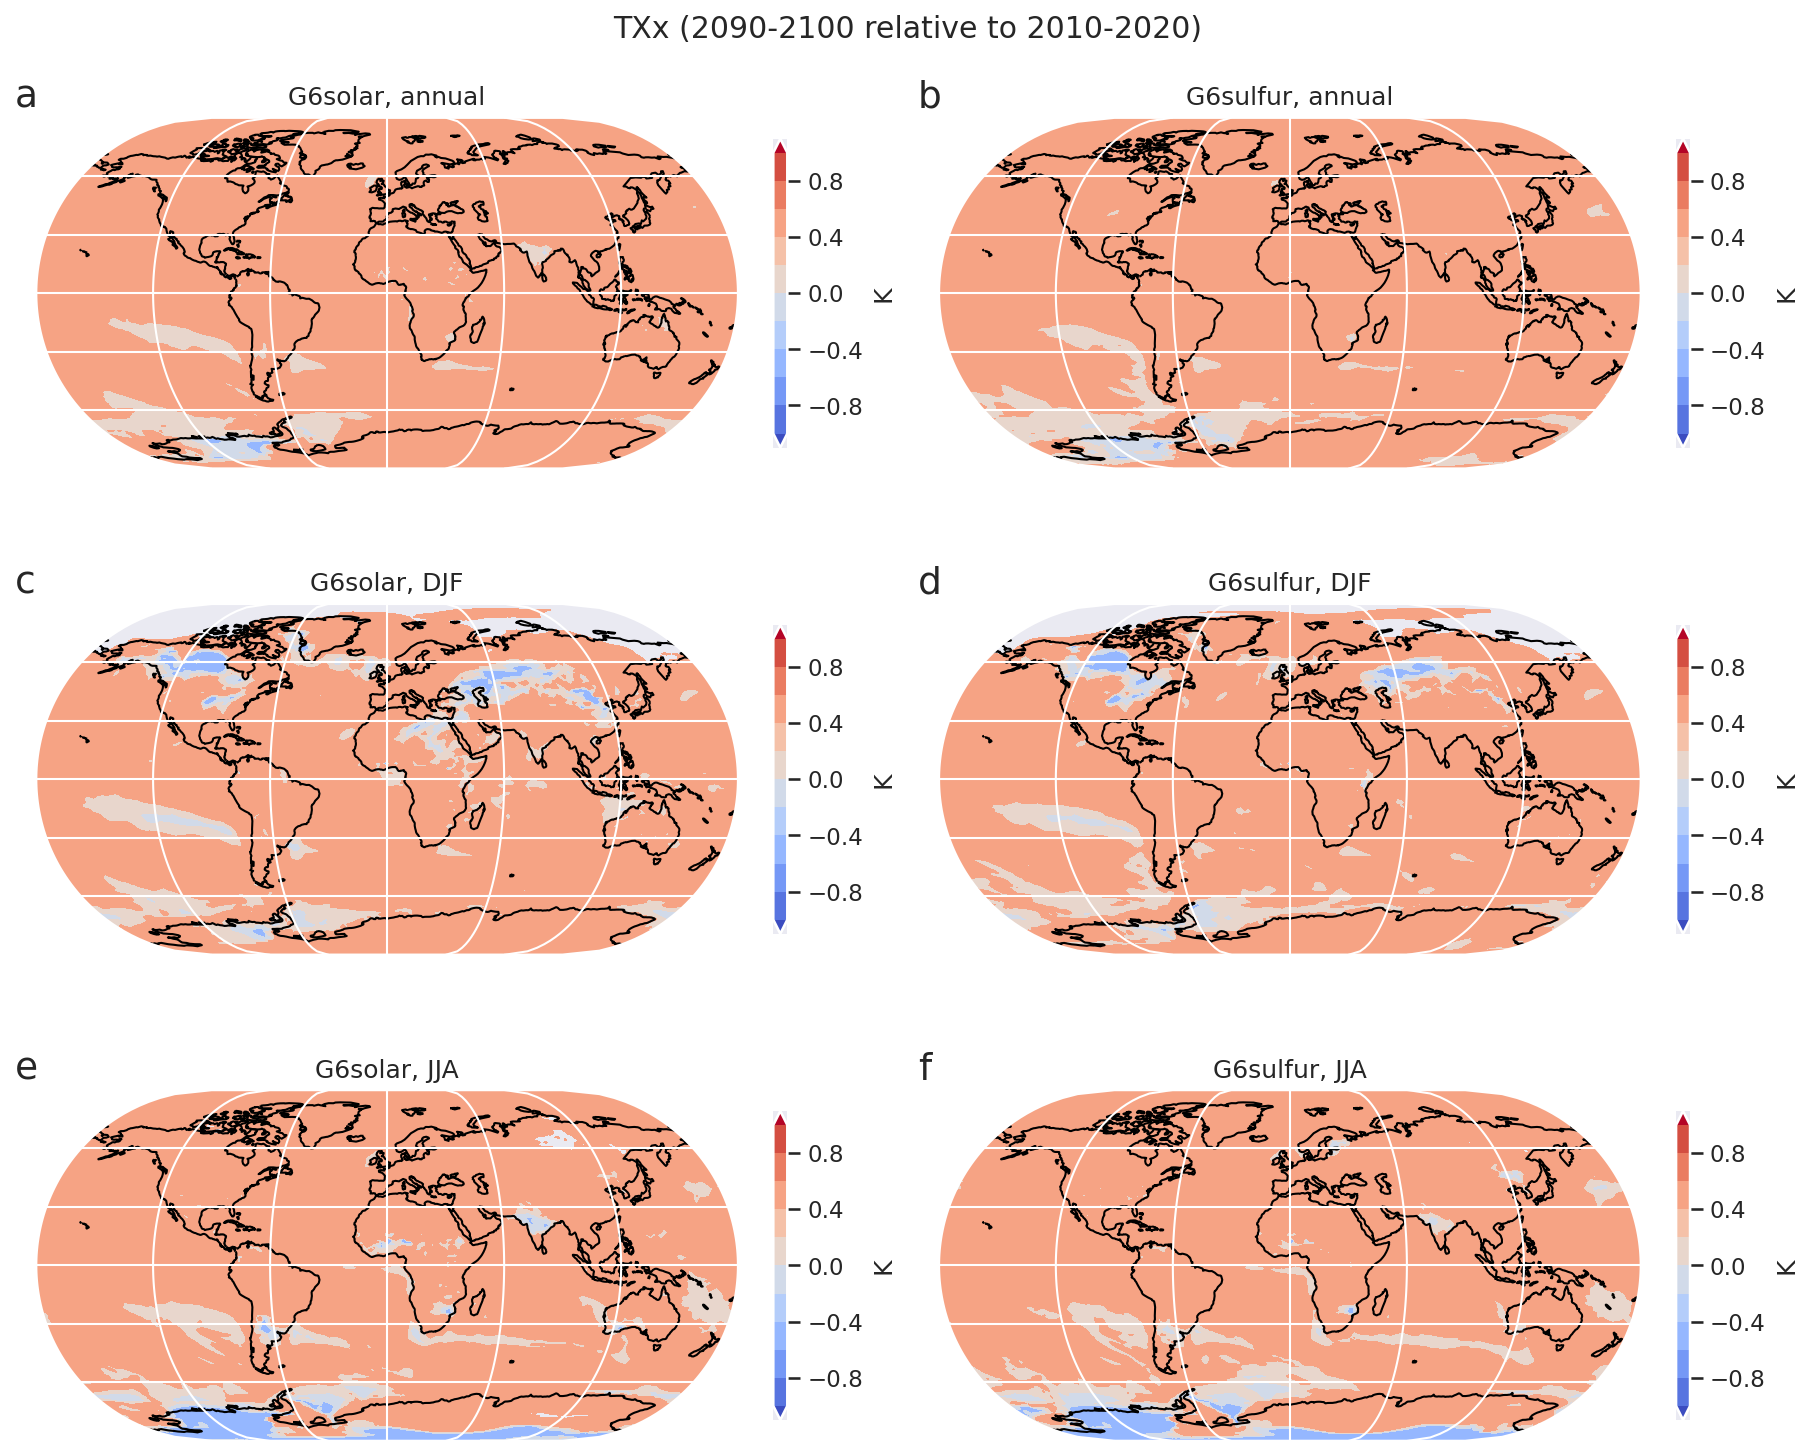

In [39]:
cmap1 = sns.diverging_palette(260,10,s=80, l=55, n=17, as_cmap=True)
cmap2 = sns.light_palette((260, 75, 60), input = "husl", reverse=True,
                          as_cmap=True)
fig = plt.figure(constrained_layout=True, figsize = (12,10), dpi= 150,
                )
ax_dict = fig.subplot_mosaic(
    """
    AB
    CD
    EF
    """,
    subplot_kw = {'projection':ccrs.EckertIII()}
)

boundaries, cmap, norm = make_colourmap(-1, 1, 11, col = 'coolwarm')


for j, ax in enumerate(fig.axes):
    dat = datnorm[j]
    lon = dat.lon.values
    lat = dat.lat.values
    if j % 2:
        l = 'G6sulfur, '
    else:
        l = 'G6solar, '
    if j < 2:
        tim = 'annual'
    elif 2 <= j < 4:
        tim = 'DJF'
    else:
        tim = 'JJA'
    ax.text(-0.03, 1.03, string.ascii_lowercase[j], transform=ax.transAxes, 
            size=18,)
    gl = ax.gridlines(crs = ccrs.PlateCarree())
    #gl.ylocator = ticker.FixedLocator([-60,-30,0,30,60])
    #gl.xlocator = ticker.FixedLocator([0,60,120,180,240,300,360])
    filled_c = ax.contourf(lon, lat, dat,
           transform=ccrs.PlateCarree(), levels=boundaries,
           cmap=cmap)
    
    cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax = ax,
                      orientation="vertical", fraction = 0.02, extend = 'both')
    cb.set_label(label = 'K')
    #ax.contourf(dat,
    #        projection=ccrs.Robinson())
    ax.coastlines()
    ax.set_title(l+tim)
    
    ax.set_global()

fig.suptitle('TXx (2090-2100 relative to 2010-2020)')
plt.show()

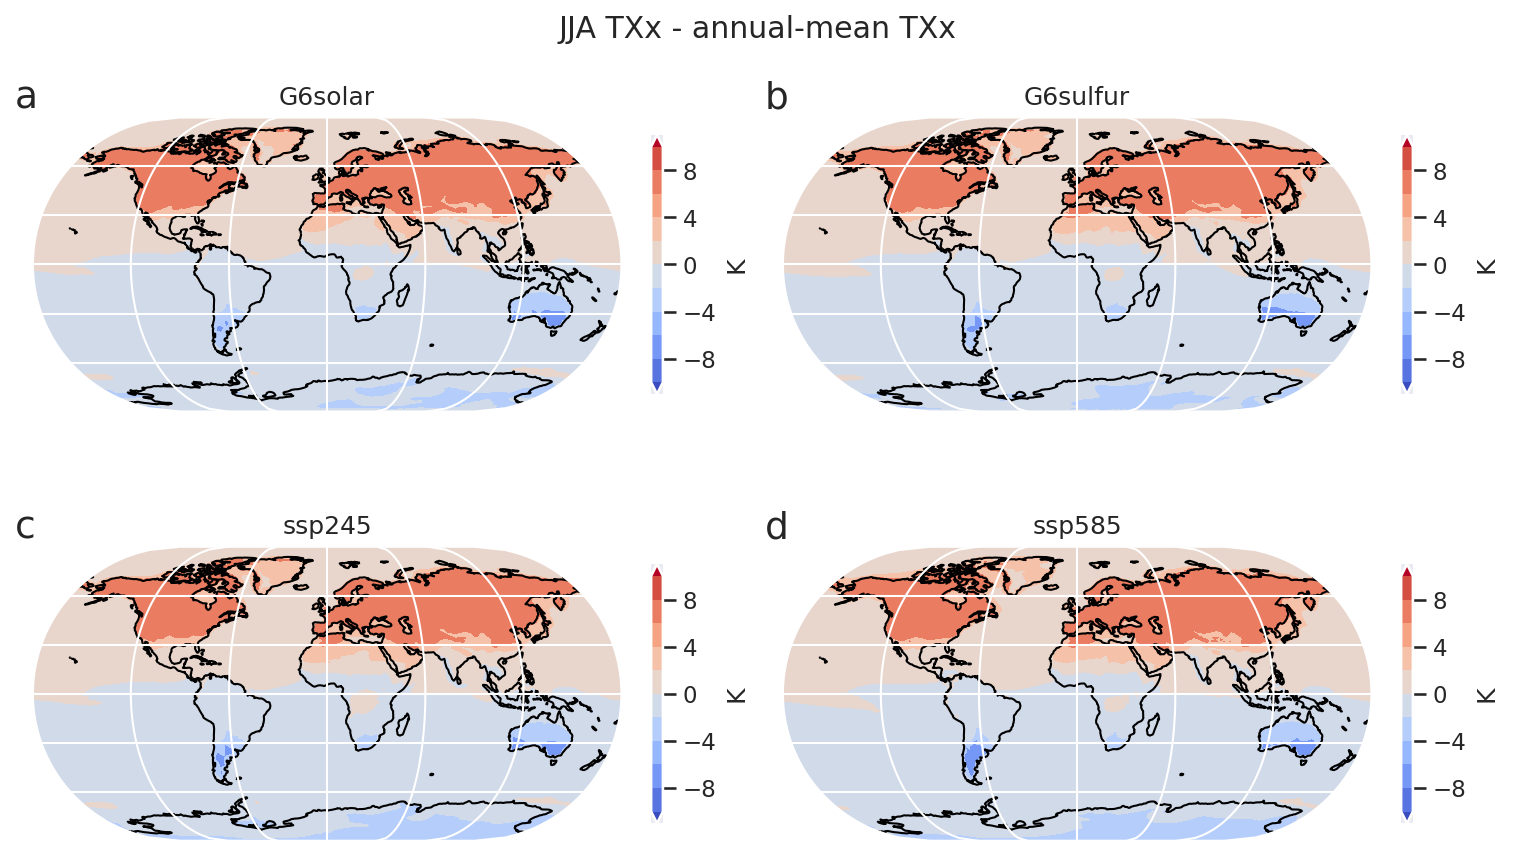

In [24]:
cmap1 = sns.diverging_palette(260,10,s=80, l=55, n=17, as_cmap=True)
cmap2 = sns.light_palette((260, 75, 60), input = "husl", reverse=True,
                          as_cmap=True)
fig = plt.figure(constrained_layout=True, figsize = (10,6), dpi= 150,
                )
ax_dict = fig.subplot_mosaic(
    """
    AABB
    CCDD
    """,
    subplot_kw = {'projection':ccrs.EckertIII()}
)

boundaries, cmap, norm = make_colourmap(-10, 10, 11, col = 'coolwarm')

for j, ax in enumerate(fig.axes):
    dat = summer[j]-modelist[j]
    lon = dat.lon.values
    lat = dat.lat.values
    l = labels[j]
    ax.text(-0.03, 1.03, string.ascii_lowercase[j], transform=ax.transAxes, 
            size=18,)
    gl = ax.gridlines(crs = ccrs.PlateCarree())
    #gl.ylocator = ticker.FixedLocator([-60,-30,0,30,60])
    #gl.xlocator = ticker.FixedLocator([0,60,120,180,240,300,360])
    filled_c = ax.contourf(lon, lat, dat,
           transform=ccrs.PlateCarree(), levels=boundaries,
           cmap=cmap)
    
    cb = fig.colorbar(cm.ScalarMappable(norm=norm, cmap=cmap), ax = ax,
                      orientation="vertical", fraction = 0.02, extend = 'both')
    cb.set_label(label = 'K')
    #ax.contourf(dat,
    #        projection=ccrs.Robinson())
    ax.coastlines()
    ax.set_title(l)
    ax.set_global()

fig.suptitle('JJA TXx - annual-mean TXx')
plt.show()